In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json

In [2]:
model = tf.keras.models.load_model("nba_stats_predictor_model.keras") # loading the model
max_sequence_length = model.input_shape[1]

In [3]:
with open("normalization_params.json", "r") as f: # loading the normalization parameters
    params = json.load(f)
    means = params["means"]
    stds = params["stds"]
    stats_columns = params["stats_columns"]

In [4]:
data_normalized = pd.read_csv("data_normalized.csv")
data_full_normalized = pd.read_csv("data_full_normalized.csv")
data_normalized.head()

,PLAYER_AGE,GP,SEASON_START_YEAR,PLAYER_NAME,MIN_PER_GAME,FGM_PER_GAME,FGA_PER_GAME,FG3M_PER_GAME,FG3A_PER_GAME,FTM_PER_GAME,...,OREB_PER_GAME,DREB_PER_GAME,REB_PER_GAME,AST_PER_GAME,STL_PER_GAME,BLK_PER_GAME,TOV_PER_GAME,PF_PER_GAME,PTS_PER_GAME,is_traded
0,-1.210760,1.149459,-1.445141,A.C. Green,-0.153427,-0.284806,-0.482820,-0.724115,-0.766991,-0.225620,...,1.079864,0.068718,0.412616,-0.676081,-0.148909,0.363463,-0.042408,1.030401,-0.345358,-0.355291
1,-0.967355,1.031047,-1.368282,A.C. Green,0.793580,0.346263,0.087211,-0.738641,-0.772483,0.848692,...,1.907163,1.402204,1.640346,-0.462926,0.467149,1.188166,0.053856,0.296719,0.372650,-0.355291
2,-0.723951,1.149459,-1.291423,A.C. Green,1.170399,0.315798,0.165326,-0.738641,-0.794450,1.399801,...,2.291682,1.698534,1.985522,-0.425624,0.828286,0.262890,0.258415,0.681029,0.478001,-0.355291
3,-0.480546,1.149459,-1.214564,A.C. Green,1.017688,0.733609,0.469342,-0.666008,-0.690106,1.309112,...,2.478116,1.808286,2.122809,-0.356349,1.019477,0.504266,0.246382,0.226844,0.776226,-0.355291
4,-0.237141,1.149459,-1.137705,A.C. Green,1.258654,0.650917,0.593904,-0.506215,-0.497895,1.274232,...,2.536376,1.599757,1.993367,-0.441611,0.275959,0.383578,0.198250,0.715966,0.722740,-0.355291


In [5]:
def inverse_normalize(normalized_preds, means, stds, columns):
    """
    Retransform normalized predictions to the original scale.
    """
    if len(normalized_preds.shape) == 1:
        original_preds = np.empty_like(normalized_preds)
        for i, col in enumerate(columns):
            original_preds[i] = normalized_preds[i] * stds[col] + means[col]
    else:
        original_preds = np.empty_like(normalized_preds)
        for i, col in enumerate(columns):
            original_preds[:, i] = normalized_preds[:, i] * stds[col] + means[col]

    return original_preds

In [6]:
predictions = []

current_season_players = data_normalized[data_normalized["SEASON_START_YEAR"] == data_normalized["SEASON_START_YEAR"].max()]["PLAYER_NAME"].unique()
for player in current_season_players:
    player_data = data_normalized[data_normalized["PLAYER_NAME"] == player]
    player_sequence = player_data.drop(columns=["PLAYER_NAME", "SEASON_START_YEAR"]).values
    player_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(
        [player_sequence], dtype="float32", maxlen=max_sequence_length, padding="pre",value=-999.0
    )

    prediction = model.predict(player_sequence_padded, verbose=0)
    original_prediction = inverse_normalize(prediction, means, stds, stats_columns)
    
    prediction_dict = dict(zip(stats_columns, original_prediction[0]))
    prediction_dict["PLAYER_NAME"] = player
    prediction_dict["SEASON_START_YEAR"] = 2025
    predictions.append(prediction_dict)

predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv('predicted_2025_2026_season.csv', index=False)

print("Predictions for the 2025-2026 season have been saved to 'predicted_2025_2026_season.csv'.")

Predictions for the 2025-2026 season have been saved to 'predicted_2025_2026_season.csv'.


In [7]:
top_10_pts_per_game = predictions_df[['PLAYER_NAME', 'PTS_PER_GAME']].sort_values(by='PTS_PER_GAME', ascending=False).head(10)
print("Top 10 Predicted Points Leaders for the 2024-2025 Season:\n")
print(top_10_pts_per_game.to_string(index=False, formatters={"PTS_PER_GAME": "{:.1f}".format}))

Top 10 Predicted Points Leaders for the 2024-2025 Season:

            PLAYER_NAME PTS_PER_GAME
            Luka Dončić         31.1
            Joel Embiid         30.2
Shai Gilgeous-Alexander         29.7
  Giannis Antetokounmpo         29.0
           Jayson Tatum         27.5
        Anthony Edwards         27.1
       Donovan Mitchell         26.5
           Nikola Jokić         25.4
          Jalen Brunson         25.3
           Devin Booker         25.3


In [8]:
top_10_reb_per_game = predictions_df[['PLAYER_NAME', 'REB_PER_GAME']].sort_values(by='REB_PER_GAME', ascending=False).head(10)
print("Top 10 Predicted Rebounds Leaders for the 2024-2025 Season:\n")
print(top_10_reb_per_game.to_string(index=False, formatters={"REB_PER_GAME": "{:.1f}".format}))

Top 10 Predicted Rebounds Leaders for the 2024-2025 Season:

          PLAYER_NAME REB_PER_GAME
     Domantas Sabonis         12.3
         Nikola Jokić         12.1
        Anthony Davis         11.5
          Rudy Gobert         11.3
Giannis Antetokounmpo         11.1
          Jalen Duren         11.1
          Joel Embiid         10.9
        Jarrett Allen         10.3
    Victor Wembanyama         10.3
        Deandre Ayton         10.2


In [9]:
top_10_ast_per_game = predictions_df[['PLAYER_NAME', 'AST_PER_GAME']].sort_values(by='AST_PER_GAME', ascending=False).head(10)
print("Top 10 Predicted Assists Leaders for the 2024-2025 Season:\n")
print(top_10_ast_per_game.to_string(index=False, formatters={"AST_PER_GAME": "{:.1f}".format}))

Top 10 Predicted Assists Leaders for the 2024-2025 Season:

      PLAYER_NAME AST_PER_GAME
      Luka Dončić          9.3
Tyrese Haliburton          9.2
       Trae Young          9.2
     Nikola Jokić          8.2
      LaMelo Ball          7.8
     LeBron James          7.6
        Ja Morant          7.2
     James Harden          7.1
 Domantas Sabonis          6.9
  Cade Cunningham          6.9


Let's see what the average error was for each category:

In [10]:
data_full = pd.read_csv("data_full.csv")

In [11]:
merged_df = predictions_df.merge(data_full, on=["PLAYER_NAME", "SEASON_START_YEAR"], suffixes=("_pred", "_actual"))

error_dict = {}
for stat in stats_columns:
    error_dict[stat] = (merged_df[f"{stat}_pred"] - merged_df[f"{stat}_actual"]).abs().mean()

print("\nAverage Absolute Errors:\n")
for stat, error in error_dict.items():
    print(f"{stat}: ±{error:.1f}")


Average Absolute Errors:

GP: ±16.3
MIN_PER_GAME: ±4.1
FGM_PER_GAME: ±0.8
FGA_PER_GAME: ±1.6
FG3M_PER_GAME: ±0.3
FG3A_PER_GAME: ±0.8
FTM_PER_GAME: ±0.4
FTA_PER_GAME: ±0.5
OREB_PER_GAME: ±0.3
DREB_PER_GAME: ±0.6
REB_PER_GAME: ±0.8
AST_PER_GAME: ±0.6
STL_PER_GAME: ±0.2
BLK_PER_GAME: ±0.1
TOV_PER_GAME: ±0.3
PF_PER_GAME: ±0.4
PTS_PER_GAME: ±2.2


Most of these are basically rounding errors. This data was excluded from the training and validation sets as well, so this proves the model is quite robust.

Note that GP is pretty high only because the 2024-25 season isn't over yet. As more games are played, that value will shrink and the other errors might actually decrease as well.

Let's predict for a random historical season.

In [12]:
lebron_data = data_normalized[data_normalized["PLAYER_NAME"] == "LeBron James"].sort_values(by="SEASON_START_YEAR").reset_index(drop=True)
lebron_sequence = lebron_data.drop(columns=["PLAYER_NAME", "SEASON_START_YEAR"]).values
lebron_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(
                        [lebron_sequence], dtype="float32", padding="pre", value=-999.0, maxlen=max_sequence_length)

prediction = model.predict(lebron_sequence_padded)

lebron_prediction_original = inverse_normalize(prediction, means, stds, stats_columns)

print(f"LeBron's Predicted Stats for the 2024-2025 Season:")
for stat, pred_val in zip(stats_columns, lebron_prediction_original[0]):
    print(f"  {stat}: {pred_val:.1f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LeBron's Predicted Stats for the 2024-2025 Season:
  GP: 59.7
  MIN_PER_GAME: 33.2
  FGM_PER_GAME: 8.6
  FGA_PER_GAME: 18.1
  FG3M_PER_GAME: 2.0
  FG3A_PER_GAME: 5.5
  FTM_PER_GAME: 3.7
  FTA_PER_GAME: 4.6
  OREB_PER_GAME: 1.0
  DREB_PER_GAME: 6.3
  REB_PER_GAME: 7.4
  AST_PER_GAME: 7.6
  STL_PER_GAME: 1.0
  BLK_PER_GAME: 0.6
  TOV_PER_GAME: 3.0
  PF_PER_GAME: 1.4
  PTS_PER_GAME: 23.1


For reference, here are his current averages (as of March 11th):
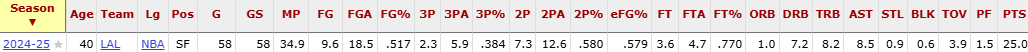

Lebron outperforming expectations as usual!

What about next season?

In [13]:
lebron_data = data_full_normalized[data_full_normalized["PLAYER_NAME"] == "LeBron James"].sort_values(by="SEASON_START_YEAR").reset_index(drop=True)
lebron_sequence = lebron_data.drop(columns=["PLAYER_NAME", "SEASON_START_YEAR"]).values
lebron_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(
                        [lebron_sequence], dtype="float32", padding="pre", value=-999.0, maxlen=max_sequence_length)

prediction = model.predict(lebron_sequence_padded)

lebron_prediction_original = inverse_normalize(prediction, means, stds, stats_columns)

print(f"LeBron's Predicted Stats for the 2025-2026 Season:")
for stat, pred_val in zip(stats_columns, lebron_prediction_original[0]):
    print(f"  {stat}: {pred_val:.1f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
LeBron's Predicted Stats for the 2025-2026 Season:
  GP: 56.4
  MIN_PER_GAME: 32.6
  FGM_PER_GAME: 8.4
  FGA_PER_GAME: 17.3
  FG3M_PER_GAME: 2.1
  FG3A_PER_GAME: 5.7
  FTM_PER_GAME: 3.2
  FTA_PER_GAME: 4.1
  OREB_PER_GAME: 1.0
  DREB_PER_GAME: 6.5
  REB_PER_GAME: 7.5
  AST_PER_GAME: 7.6
  STL_PER_GAME: 1.0
  BLK_PER_GAME: 0.6
  TOV_PER_GAME: 3.0
  PF_PER_GAME: 1.5
  PTS_PER_GAME: 22.0
